# 타이타닉 생존자 예측 해보기

Survived : 0 = 사망, 1 = 생존  
Pclass : 1 = 1등석, 2 = 2등석, 3 = 3등석  
Sex : male = 남성, female = 여성  
Age : 나이  
SibSp : 타이타닉 호에 동승한 자매 / 배우자의 수  
Parch : 타이타닉 호에 동승한 부모 / 자식의 수  
Ticket : 티켓 번호  
Fare : 승객 요금  
Cabin : 방 호수  
Embarked : 탑승지, C = 셰르부르, Q = 퀸즈타운, S = 사우샘프턴  

## 1. 문제 정의

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('./train (1).csv')
test = pd.read_csv('./test (1).csv')

train.head()    

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


데이터는 타이타닉호 탑승객들의 신상 정보를 series로 갖는 dataframe으로 구성 되어있다.  
승객별로 생존 여부가 모두 라벨링 되어있으므로 지도학습에 해당된다.  
또한 여러개의 변수를 이용하여 최종적으로 생존(1), 사망(0)을 나눠야 하는 이진 분류 문제이다.

## 2. 데이터 살펴보기

데이터는 학습 시키기 전 전처리를 해서 깨끗한 상태로 정제 해야한다. 이를 위해 데이터의 형태와 크기를 알아보고  
결측치를 파악하여 어떠한 상태로 가공할 것인지 방향을 정한다.

### 2.1 데이터 딕셔너리

데이터의 각 column은 Name, Age등 직관적으로 파악이 되는 경우도 있지만, sibSp, Parch등 과 같이 의미하는 바가 명확하지 않은 경우도 있다.

### 2.2 결측치 파악  
우선 데이터의 형태를 알아보자.

In [4]:
train.shape

(891, 12)

In [5]:
test.shape

(418, 11)

훈련 데이터는 891개의 행과 12개의 열로 이루어져있다.  
훈련 데이터로 학습 시킨 모델을 통해 라벨링을 해야하므로 타깃(라벨)에 해당하는 survived열이 빠진 상태이다.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


info()는 dataframe에 대해 각 series(column)의 타입(정수, 실수, 문자등)과 결측치 개수의 정보를 요약해서 보여준다.  
결측치가 정확히 몇 개 인지는 아래 코드를 통해 확인할 수 있다.  

pandas의 info()는 메소드는 dataframe에만 적용할 수 있고, series에는 쓸 수 없다.

In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## 2.3 데이터 시각화 

각 column들을 시각화 하여 대략적인 분포를 파악하고 타겟(생존여부)과의 상관 관계를 유추한다.  
우선 명목형, 이산형 데이터들에 대해 막대형 그래프를 그려주는 함수를 하나 정의한다.

In [10]:
def bar_chart(feature):
    # 각 column(=feature)에서 생존자 수 count
    survived = train[train['Survived']==1][feature].value_counts()
    
    # 각 column(=feature)에서 사망자 수 count
    dead = train[train['Survived']==0][feature].value_counts()
    
    # 생존자수, 사망자수를 하나의 dataframe으로 묶는다.
    df = pd.DataFrame([survived, dead])
    
    # 묶은 dataframe의 인덱스명(행 이름)을 지정한다.
    df.index = ['Survived', 'Dead']
    
    # plot을 그린다.
    df.plot(kind='bar', stacked=True, figsize=(10,5))
#     return df

pandas의 value_counts()는 dataframe에는 적용할 수 없고, series에 적용한다.  
해당 메서드의 return값 역시 series이다.

명목, 이산형 데이터에 해당하는 feature들의 그래프를 그려보자. SibSp와 parch는 의미상 큰 차이가 없으므로 하나만 그린다. 

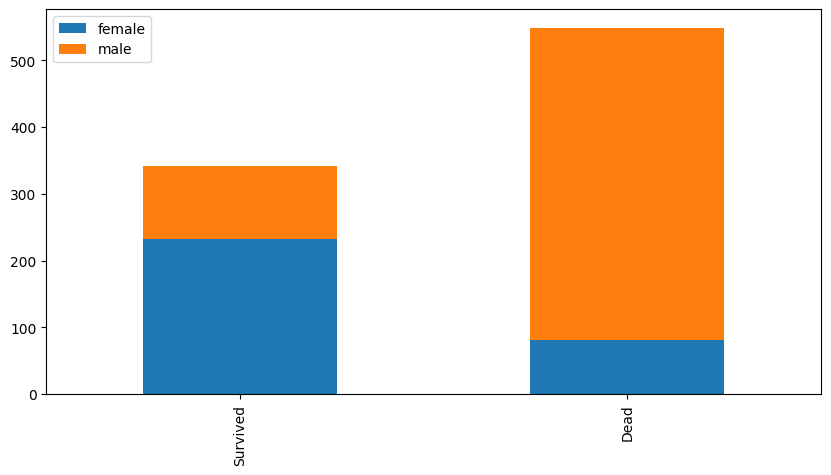

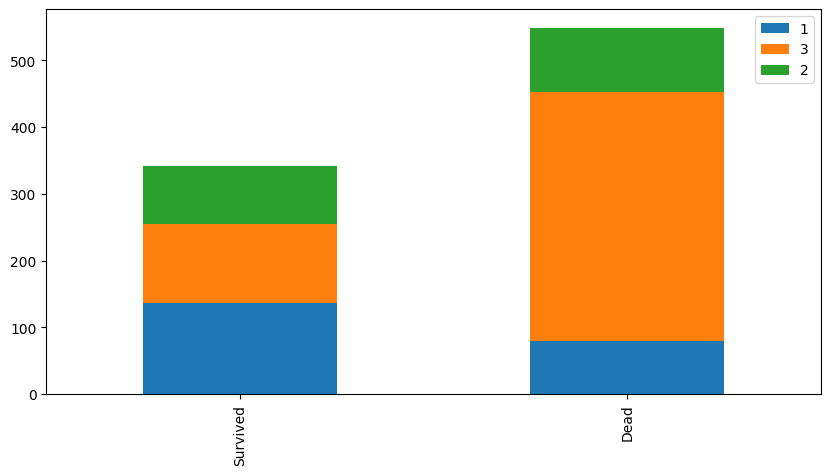

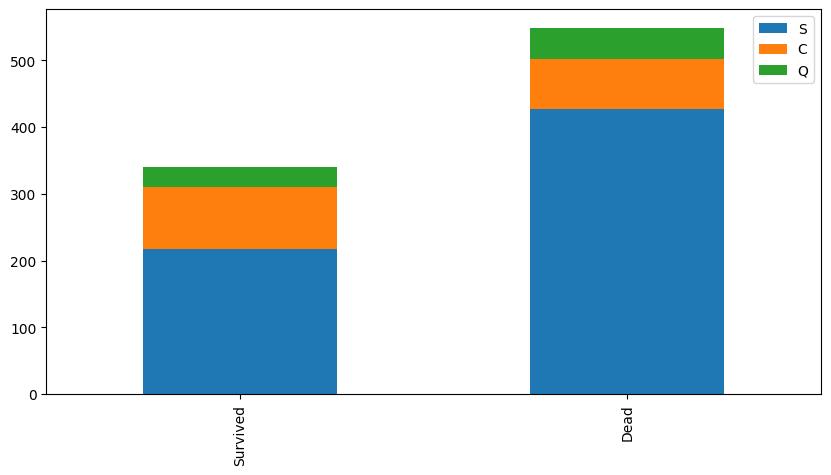

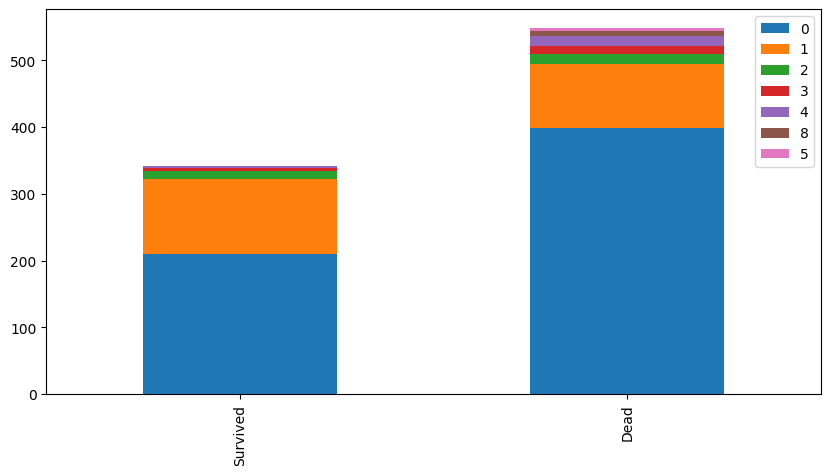

In [11]:
bar_chart('Sex')
bar_chart('Pclass')
bar_chart('Embarked')
bar_chart('SibSp')

데이터를 시각화 하여 분석한 결과 남성보단 여성이 많이 생존 했으며 1등급 승객, 가족이 있는 승객이 생존률이 높았다.   
탑승 지역에서의 특별한 경향은 아직 보인다고 말하긴 어려워 보이지만 비율상으로 S 승객들이 많이 사망했다.

# 3. 데이터 전처리

정제가 필요한 column에 대해서 전처리를 진행한다.

## 3.1 Sex

성별 데이터는 결측치도 없고 분류도 이미 끝나있다. 학습이 잘 진행될 수 있도록 각 문자들을 숫자에 대응시킨다.

In [12]:
train_test_data = [train, test]

sex_mapping = {'male': 0, 'female': 1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

testset과 trainset을 모두 전처리 해야 하므로 하나의 리스트로 묶어 for문을 통해 한번에 처리하도록 한다. 

In [13]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


## 3.2 SibSp & Parch

해당 칼럼이 의미하는 바는 결국 가족의 수이다.  
앞서 시각화에서 관찰했듯이 동승자의 여부는 생존율과 유의미한 관계가 있으므로 SibSp와 parch를 familysize로 묶는다.  
그리고 이를 통해 동승자 여부를 판단하는 IsAlone이라는 변수를 생성한다.

In [14]:
for dataset in train_test_data:
    # 가족수 = 형제자매 + 부모님 + 자녀 + 본인
    dataset['Familysize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1

    # 가족수 1 이상이면 동승자 있음
    dataset.loc[dataset['Familysize']>1, 'IsAlone'] = 0

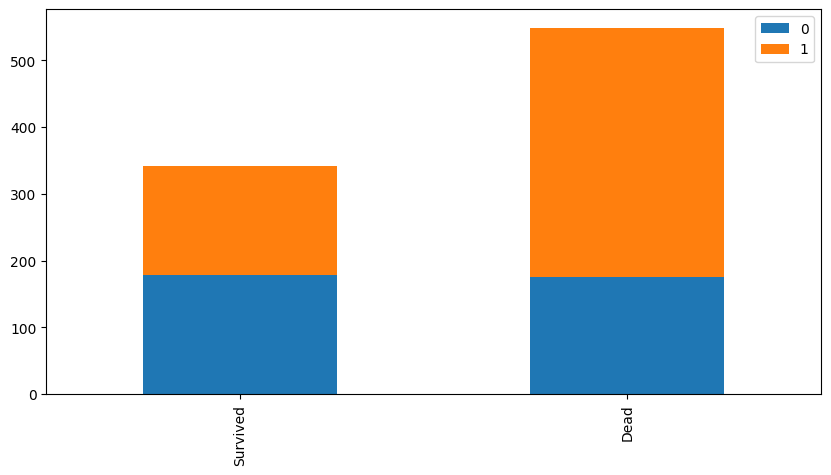

In [15]:
bar_chart('IsAlone')

위에서 확인한대로 혼자 탄 사람이 많이 죽었음을 확인할 수 있다.  

In [16]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familysize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1,1


## 3.3 Embarked

시각화 결과 S승객들이 사망한 비율이 높았다. 거주지역의 차이가 경제적 지표를 나타낼 수도 있으므로 등급별 승객들의 지역 분포를 시각화해서 살펴보자.

<Axes: >

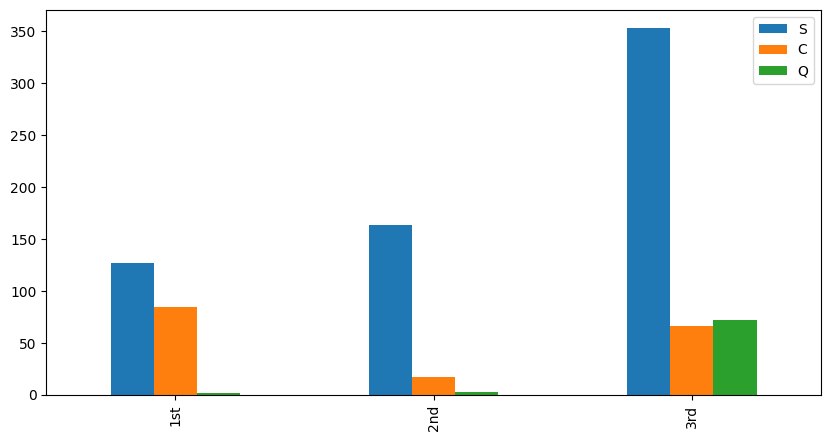

In [17]:
class_list = []
for i in range(1,4):
    series = train[train['Pclass'] == i]['Embarked'].value_counts()
    class_list.append(series)

df = pd.DataFrame(class_list)
df.index = ['1st', '2nd', '3rd']
df.plot(kind='bar', figsize=(10,5))

series = train[train['Pclass'] == i]['Embarked'].value_counts(): 이 코드 행은 train DataFrame을 필터링하여 Pclass 열이 현재 열과 일치하는 행을 선택합니다. 'i'의 값. 그런 다음 필터링된 행에서 'Embarked' 열을 검색하고 'value_counts()' 함수를 사용하여 각 고유 값의 개수를 계산합니다. 결과는 series 변수에 저장됩니다.  

class_list.append(series): class_list 목록에 series 개체를 추가합니다. 각 'series' 개체는 특정 'Pclass'의 승객 수를 나타냅니다.  

결과 class_list는 3개의 series 개체 목록이 되며 각 series 개체는 특정 승객 클래스의 승객 수를 나타냅니다. 각 'series' 객체는 고유한 승선 포트를 인덱스로, 각 포트의 승객 수를 해당 값으로 갖습니다.

Q지역이 비교적 다른 지역보다 못사는것으로 보인다. 그러나 대부분 S지역에서 탑승했으므로 Embarked의 결측치는 S로 채운다.

In [18]:
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

성별과 마찬가지로 탑승 지역을 숫자에 매핑하고 결과를 확인한다.

In [19]:
embarked_mapping = {'S':0, 'C':1, 'Q':2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familysize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1


## 3.4 Name

이름 자체가 생존율과 유의미한 관계가 있다고 보기는 어렵다.   
그러나 서양인들의 이름은 그 사람의 성별(Mr, Mrs), 혼인 여부(Miss)를 포함한다.  
성별은 그 자체로 생존율과 관계가 있고, 혼인 여부는 동승 여부를 어느정도 반영하고 있으므로 해당 부분만 추출한다. 대표적인 영어 호칭에 대한 내용은 다음과 같다.  

Mr.	성인 남성  
Mrs.	결혼을 한 여성  
Ms.	결혼 여부를 밝히고 싶지 않을 때 사용하는 여성 호칭  
Miss	결혼을 하지 않은 여성  
Master	결혼을 하지 않은 남성. 주로 청소년 이하  

In [20]:
for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract('([\w]+)\.', expand=False)

우리가 추출하고 싶은 호칭(Mr, Miss)들은 모두 마침표(.)로 끝난다는 공통점이 있으므로 정규표현식을 통해 이를 지정한 것이다.  
역슬래시를 포함한 \w는 숫자를 포함한 임의의 문자(공백, 기호, 특수문자 제외)를 지칭하고 \.은 마침표(.) 자체를 의미한다.

In [21]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familysize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,2,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,Mr


영어 호칭의 종류 및 분포를 확인하기 위해 value_counts() 메서드를 이용한다.

In [22]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [23]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64

성별, 지역과 마찬가지로 각 호칭들을 숫자에 매핑한다. Mr, Miss, Mrs, Master가 대부분을 차지하고 있으므로 나머지 호칭에 대해서는 하나로 취급한다.

In [24]:
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].apply(lambda x: 0 if x=="Mr" else 1 if x=="Miss" else 2 if x=="Mrs" else 3 if x=="Master" else 4)

pandas의 apply 매서드는 series, dataframe의 각 entry에 접근하여 특별한 조작을 하고 싶을 때 많이 이용한다.  
series에 매서드를 적용하면 리턴값은 보통 series이지만 어떤 조작을 하느냐에 따라 dataframe이 출력될 수도 있다.  
dataframe에 대해서도 결과값은 series이거나 dataframe이다.

apply에서는 lambda를 이용할 수 있는데 lambda 변수명 : 변수에 대한 조작 내용 으로 이용한다. 위의 코드를 기준으로 lambda 다음에 오는 x는 우리가 접근하고자 하는 Title series의 성분 하나 하나를 의미한다.

In [25]:
train['Title'].value_counts()

0    517
1    182
2    125
3     40
4     27
Name: Title, dtype: int64

In [26]:
test['Title'].value_counts()

0    240
1     78
2     72
3     21
4      7
Name: Title, dtype: int64

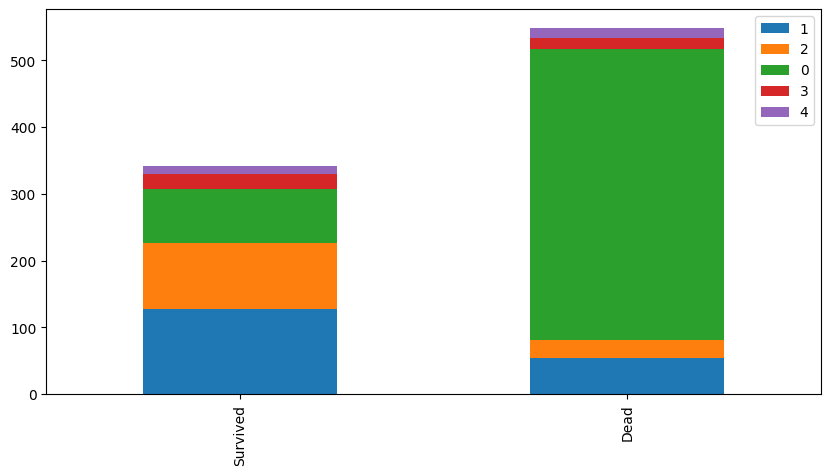

In [27]:
bar_chart('Title')

성인 남성에 해당하는 Mr가 압도적으로 사망률이 높았으며, 여성에 해당하는 Miss와 Mrs는 많이 생존하으나  
가족이 없는 Miss쪽이 생존율이 더 낮은 것을 확인할 수 있다.  
Master는 남성이지만 어린 아이가 많아 생존률이 더 높다. 매핑이 잘 이루어졌는지 보자.

In [28]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familysize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,2,0,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2,0,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,0


## 3.5 Cabin

Cabin은 방 번호이다. 데이터가 어떻게 구성되어 있는지 살펴보자

In [29]:
train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [30]:
train['Cabin'] = train['Cabin'].str[:1]

가족 단위로 비슷한 방 번호를 받았으니 선실이 같으면 같은 등급의 클래스일 가능성이 높을 것이다.  
알파벳과 클래스와의 상관관계를 시각화하여 살펴본다.

<Axes: >

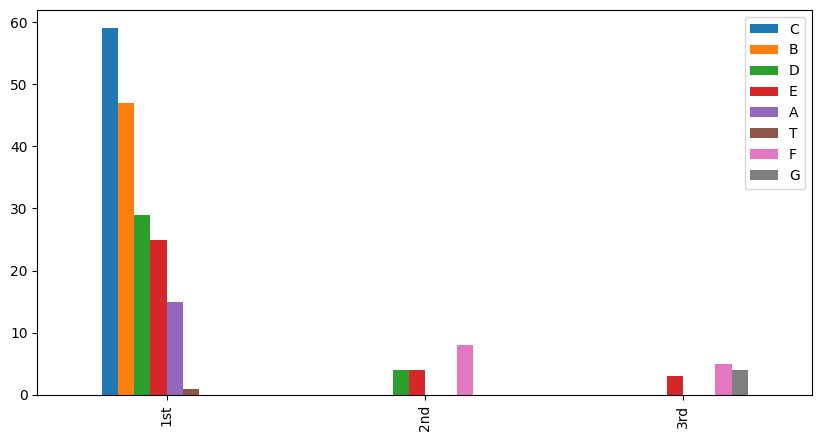

In [31]:
class_list = []
for i in range(1,4):
    a = train[train['Pclass'] == i]['Cabin'].value_counts()
    class_list.append(a)

df = pd.DataFrame(class_list)
df.index = ['1st', '2nd', '3rd']
df.plot(kind='bar', figsize=(10,5))

우선 1등급과 3등급이 공유하는 알파벳이 없다. 그러나 Cabin에 대한 정보는 결측치가 과반수 이상이고, 그 마저도 1등급에 편향되어있다.  
등급별 생존율을 살펴보면, 1등급은 생존율이 더 높으며, 2등급은 비슷하고, 3등급은 사망률이 더 높다.  
등급별 Cabin 데이터의 유실률은 이를 제대로 반영하고 있지 않으므로 삭제 처리한다.

## 3.6 Age

나이 정보엔 결측치가 존재한다. 우선 승객들 전원의 평균으로 채워넣는 방법을 생각해볼 수 있다.  
그러나 승객들의 Title이 나이대를 어느정도 반영하고 있으므로 각 Title에 해당하는 그룹의 중간값으로 결측치를 메꾼다.

In [32]:
for dataset in train_test_data:
    dataset['Age'].fillna(dataset.groupby('Title')['Age'].transform("median"), inplace=True)

1. dataset['Age']: 데이터세트에서 'Age' 열을 선택합니다.  
2. fillna(): 누락된 값을 지정된 값으로 채우는 pandas 함수입니다. 이 경우 누락된 연령 값을 채우는 데 사용됩니다.  
3. dataset.groupby('Title')['Age']: 'Title' 열을 기준으로 데이터셋을 그룹화하고 각 그룹 내에서 'Age' 열을 선택합니다. '제목' 열의 고유한 값을 기반으로 데이터 세트의 하위 집합을 만듭니다.  
4. transform("median"): 'Age' 열의 각 그룹에 "median" 집계 함수를 적용합니다. 각 그룹 내 평균 연령을 계산합니다.  
5. inplace=True: 이 매개변수는 'Age' 열을 제자리에서 수정합니다. 즉, 새 열을 생성하지 않고 원래 데이터 세트에서 직접 값을 변경합니다.  


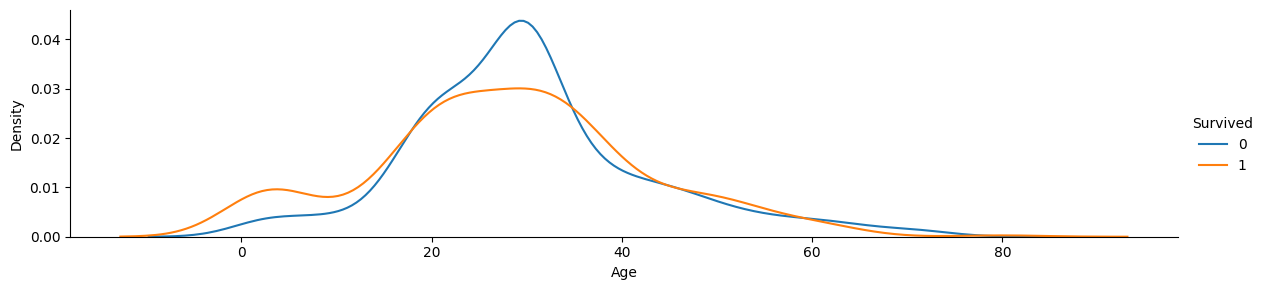

In [33]:
g = sns.FacetGrid(train, hue="Survived", aspect=4)
g = (g.map(sns.kdeplot, 'Age').add_legend()) # add_legend()는 범주를 추가하는 파라미터이다.

grouping 기준은 여러가지가 있을 수 있다. 생존그래프와 사망그래프의 교점을 기준으로 할 수 있겠지만, 두 그래프의 교점을 파악하는 방법을 찾지 못했다.  
또한 해당 교점은 train 데이터만을 설명하는 너무 특수한 기준일 수 있다.  

그래프의 분포가 정규분포와 유사하므로 승객들을 동일 구간 기준으로 흔히 사용하는 기준인 "청소년, 청년, 중년, 장년, 노년" 5개의 집단으로 나눈다.

In [34]:
for dataset in train_test_data:
    dataset['Agebin'] = pd.cut(dataset['Age'], 5, labels=[0,1,2,3,4])

pandas의 cut 메서드는 array를 인수로 받아 "길이"를 기준으로 데이터를 나눈다. 일반적으로 np.array 또는 pd.series가 인수로 들어온다.  
labels 파라미터는 데이터를 나눈 뒤 이름을 부여한다.

pandas의 qcut메서드는 cut과 유사하며 "개수"를 기준으로 데이터를 나누는 점이 다르다.

In [35]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familysize,IsAlone,Title,Agebin
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,1,2,0,2,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C,0,2,0,2,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,0,2


직접 데이터가 나뉘는 지점을 정해서 나누고 싶다면 다음 코드를 실행하면 된다. 여기서는 이용하지 않는다.

In [36]:
# for dataset in train_test_data:
#     dataset.loc[dataset['Age'] <= 15, 'Age'] = 0
#     dataset.loc[dataset['Age'] > 15 & (dataset['Age'] <= 25), 'Age'] = 1
#     dataset.loc[dataset['Age'] > 25 & (dataset['Age'] <= 35), 'Age'] = 2
#     dataset.loc[dataset['Age'] > 35 & (dataset['Age'] <= 45), 'Age'] = 3
#     dataset.loc[dataset['Age'] > 45 & (dataset['Age'] <= 60), 'Age'] = 4
#     dataset.loc[dataset['Age'] > 60, 'Age'] = 6

## 3.7 Fare

탑승 요금은 높은 등급의 승객일수록 높다. 따라서 Fare의 결측치는 각 승객 등급별 중간값으로 채운다.

In [37]:
for dataset in train_test_data:
    dataset['Fare'].fillna(dataset.groupby('Pclass')['Fare'].transform('median'), inplace=True)

그래프를 그려 그룹화의 기준을 찾는다.

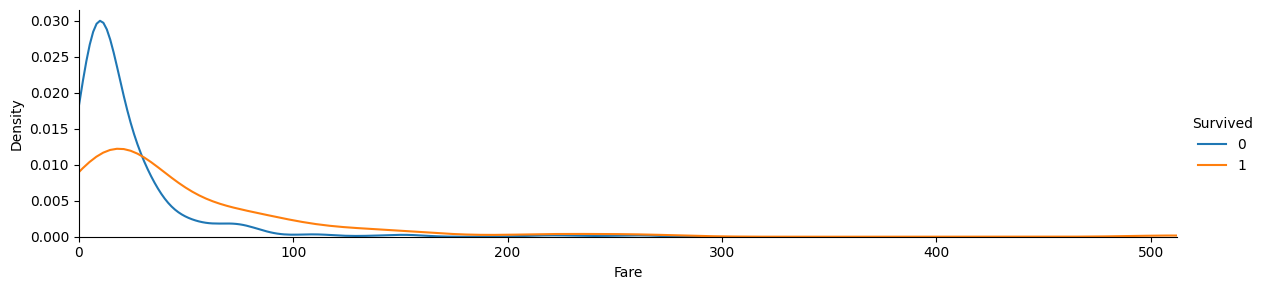

In [43]:
g = sns.FacetGrid(train, hue='Survived', aspect=4)
g = (g.map(sns.kdeplot, 'Fare')
     .add_legend() # 범주 추가
     .set(xlim=(0, train['Fare'].max()))) # X축 범위 설정

승객별로 탑승요금의 편차가 굉장히 크고 분포는 우측 꼬리가 길게 편향되어 있다.  
따라서 데이터를 그룹화 할때 길이가 아닌 개수를 기준으로 나눈다음 Farebin이라는 열에 저장한다.

In [46]:
for dataset in train_test_data:
    dataset['Farebin'] = pd.qcut(dataset['Fare'], 4, labels=[0,1,2,3])

구간이 어떤 값을 기준으로 나눠졌는지 알고 싶다면 다음으로 확인하면 된다.

In [45]:
pd.qcut(train['Fare'], 4)

0       (-0.001, 7.91]
1      (31.0, 512.329]
2       (7.91, 14.454]
3      (31.0, 512.329]
4       (7.91, 14.454]
            ...       
886     (7.91, 14.454]
887     (14.454, 31.0]
888     (14.454, 31.0]
889     (14.454, 31.0]
890     (-0.001, 7.91]
Name: Fare, Length: 891, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 7.91] < (7.91, 14.454] < (14.454, 31.0] < (31.0, 512.329]]

In [47]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familysize,IsAlone,Title,Agebin,Farebin
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,1,2,0,2,2,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C,0,2,0,2,2,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,0,2,1


전처리가 끝났거나 훈련에 이용하지 않을 column들은 삭제한다.

In [48]:
drop_column = ['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin']

for dataset in train_test_data:
    dataset = dataset.drop(drop_column, axis=1, inplace=True)

pandas의 drop 메서드는 index(행) 혹은 series(열) 이름을 인수로 받아 해당하는 행 또는 열을 삭제한다. axis 파라미터는 0일경우 행, 1일경우 열을 의미한다.

In [49]:
train.head()

,PassengerId,Survived,Pclass,Sex,Embarked,Familysize,IsAlone,Title,Agebin,Farebin
0,1,0,3,0,0,2,0,0,1,0
1,2,1,1,1,1,2,0,2,2,3
2,3,1,3,1,0,1,1,1,1,1
3,4,1,1,1,0,2,0,2,2,3
4,5,0,3,0,0,1,1,0,2,1


각 feature들에 대한 전처리는 이것으로 완료 됐다. 결측치가 제대로 채워졌는지 확인한다.

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Sex          891 non-null    int64   
 4   Embarked     891 non-null    int64   
 5   Familysize   891 non-null    int64   
 6   IsAlone      891 non-null    int64   
 7   Title        891 non-null    int64   
 8   Agebin       891 non-null    category
 9   Farebin      891 non-null    category
dtypes: category(2), int64(8)
memory usage: 58.0 KB


In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    int64   
 1   Pclass       418 non-null    int64   
 2   Sex          418 non-null    int64   
 3   Embarked     418 non-null    int64   
 4   Familysize   418 non-null    int64   
 5   IsAlone      418 non-null    int64   
 6   Title        418 non-null    int64   
 7   Agebin       418 non-null    category
 8   Farebin      418 non-null    category
dtypes: category(2), int64(7)
memory usage: 24.2 KB


# 4. 데이터 학습

PassengerId는 승객들 연번에 불과하므로 학습시키지 않는다. Survived역시 결과에 해당하므로 학습시켜선 안된다.  
따로 떼어서 target에 저장하고 훈련 데이터에선 삭제한다.

In [52]:
drop_column2 = ['PassengerId', 'Survived']
train_data = train.drop(drop_column2, axis=1)
target = train['Survived']

데이터 학습, 모델 생성 및 평가에 필요한 패키지들을 import 한다.  
데이터 분류에 이용할 수 있는 기법인 의사결정나무, 랜덤포레스트, 나이브 베이즈 분류, 서포트 벡터 머신, 로지스틱 회귀 다섯개를 이용한다. 

In [53]:
from sklearn.tree import DecisionTreeClassifier # 의사결정나무
from sklearn.ensemble import RandomForestClassifier # 랜덤 포레스트
from sklearn.naive_bayes import GaussianNB # 나이브 베이즈 분류
from sklearn.svm import SVC # 서포트 벡터 머신
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀

In [54]:
clf = LogisticRegression()
clf.fit(train_data, target)
clf.score(train_data, target)

0.8103254769921436

In [56]:
clf = DecisionTreeClassifier()
clf.fit(train_data, target)
clf.score(train_data, target)

0.8900112233445566

In [57]:
clf = RandomForestClassifier()
clf.fit(train_data, target)
clf.score(train_data, target)

0.8900112233445566

In [58]:
clf = GaussianNB()
clf.fit(train_data, target)
clf.score(train_data, target)

0.7968574635241302

In [59]:
clf = SVC()
clf.fit(train_data, target)
clf.score(train_data, target)

0.8338945005611672

의사 결정나무가 점수가 가장 높으므로 해당 모델을 테스트 데이터에 적용한다.

In [60]:
clf = DecisionTreeClassifier()
clf.fit(train_data, target)
test_data = test.drop("PassengerId", axis=1)
predict = clf.predict(test_data)

test 데이터에서도 train과 마찬가지로 PassingerId는 삭제한다. test 데이터를 모델에 적용해서 예측한 결과를 predict에 저장한다.

In [61]:
submission = pd.DataFrame({
    'PassengerId' : test['PassengerId'],
    'Survived' : predict})

submission.to_csv('submission.csv', index=False)

예측 결과를 PassengerId와 매치시켜 dataframe으로 묶은뒤 csv 파일로 저장한다.

In [62]:
submission = pd.read_csv('submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
